In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import optim
from sklearn.utils import shuffle
from torch.autograd import Variable
from torch import nn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
print(f'matplotlib: {matplotlib.__version__}')
print(f'pytorch   : {torch.__version__}')
print(f'pandas    : {pd.__version__}')
print(f'numpy     : {np.__version__}')

matplotlib: 3.2.2
pytorch   : 1.8.1+cu101
pandas    : 1.1.5
numpy     : 1.19.5


In [3]:
df = pd.read_csv("titanic.csv")
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
def format_feats(in_feats):
    x = in_feats.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=in_feats.columns)

def format_data(data):
    data = pd.get_dummies(data, columns=['Sex','Embarked'])
    data = data.drop(['Name','Ticket','Cabin'], axis=1)
    data.fillna(data.mean(), inplace=True)
    if 'Survived' in data.columns:
        data_y = data['Survived']
        data_x = data.drop(['Survived'], axis=1)
        data_x = format_feats(data_x)
        return data_x, data_y
    else:
        return format_feats(data)

feats, labels = format_data(df)
feats.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.500000,0.654321,0.367921,0.065376,0.063599,0.062858,0.352413,0.647587,0.188552,0.086420,0.722783
std,0.289162,0.418036,0.163383,0.137843,0.134343,0.096995,0.477990,0.477990,0.391372,0.281141,0.447876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.500000,0.271174,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,1.000000,0.367921,0.000000,0.000000,0.028213,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.750000,1.000000,0.434531,0.125000,0.000000,0.060508,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
train_X, test_X, train_y, test_y = train_test_split(
    feats, labels, test_size=0.2, random_state=2, stratify=labels)

In [6]:
trn_X = torch.Tensor(train_X.to_numpy())
trn_y = torch.Tensor(train_y.to_numpy()).type(torch.LongTensor)
tst_X = torch.Tensor(test_X.to_numpy())
tst_y = torch.Tensor(test_y.to_numpy()).type(torch.LongTensor)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [8]:
drpout = 0.2
inputs = len(trn_X[0])

def set_weight_bias(layer):
    layer.bias.data.fill_(0)
    layer.weight.data.normal_(std=0.01)

def construct_model(inputs, n=[32], outputs=2,
                    activ=nn.ReLU):
    n.append(outputs)
    
    layers = []
    layers.append(nn.Linear(inputs, n[0]))
    set_weight_bias(layers[-1])
    layers.append( nn.Dropout(p=drpout) )
    layers.append(activ())
    
    for i in range(len(n)-1):
        layers.append(nn.Linear(n[i], n[i+1]))
        set_weight_bias(layers[-1])
        layers.append(nn.Dropout(p=drpout))
        layers.append(activ())
        
    layers.pop()
    layers.pop()
    
    return nn.Sequential(*layers)

In [9]:
def create_plots(train_losses, test_losses, test_data, accuracy):
  
    plt.subplot(211)
    plt.ylabel('Accuracy')
    plt.plot(accuracy)
    plt.subplot(212)
    plt.ylabel('Loss')
    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.legend();

    y_pred = model(test_data[0])
    y_pred = y_pred.to('cpu')
    y_hat=torch.argmax(y_pred, dim=1)
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    class_names=["survived", "not survived"]
    conf=confusion_matrix(test_data[1], y_hat)

    print(f"\n\nprecision: {precision_score(test_data[1], y_hat, average='weighted')}")
    print(f"recall: {recall_score(test_data[1], y_hat, average='weighted')}")
    print(f"f1 score: {f1_score(test_data[1], y_hat, average='weighted')}")

    cmd = ConfusionMatrixDisplay(conf, display_labels=class_names)
    cmd.plot()
    cm = confusion_matrix(test_data[1], y_hat, normalize='all')
    cm

In [10]:
def train_model(model, train_data, test_data, epochs=5, verbose=False):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses, test_losses = [0]*epochs, [0]*epochs
    accuracy = [0]*epochs

    for e in range(epochs):
        optimizer.zero_grad()
        ps = model(train_data[0])
        loss = criterion(ps, train_data[1])
        loss.backward()
        optimizer.step()
        train_losses[e] = loss.item()

        with torch.no_grad():
            model.eval()
            
            ps = model(test_data[0])
            loss = criterion(ps, test_data[1])
            test_losses[e] = loss.item()
            
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == test_data[1].view(*top_class.shape))
            accuracy[e] = torch.mean(equals.type(torch.FloatTensor))
            
        model.train()
        
    print(f'   Accuracy  : {100*accuracy[-1].item():0.2f}%')
    print(f'   Train loss: {train_losses[-1]}')
    print(f'   Test loss : {test_losses[-1]}')

    create_plots(train_losses, test_losses, test_data, accuracy)

Test 1:
Sequential(
  (0): Linear(in_features=11, out_features=256, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=2, bias=True)
)
   Accuracy  : 81.56%
   Train loss: 0.40118280053138733
   Test loss : 0.44897639751434326


precision: 0.8177653631284916
recall: 0.8156424581005587
f1 score: 0.8102848959073211


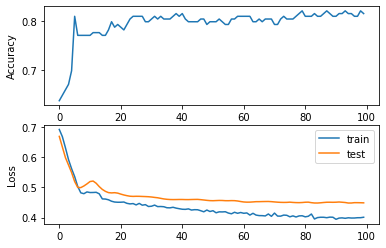

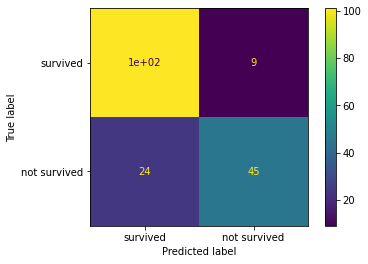

In [11]:
print("Test 1:")
model = construct_model(inputs, n=[256])
print(model)

train_model(model, epochs=100,
            train_data=(trn_X,trn_y), test_data=(tst_X,tst_y))

Test 2:
Sequential(
  (0): Linear(in_features=11, out_features=256, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=64, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=2, bias=True)
)
   Accuracy  : 79.33%
   Train loss: 0.24078047275543213
   Test loss : 0.5912138819694519


precision: 0.7861573982579859
recall: 0.7877094972067039
f1 score: 0.783090697269083


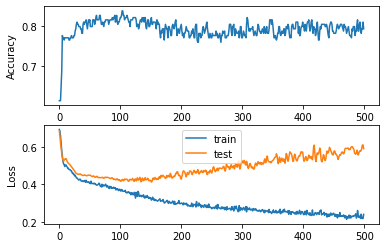

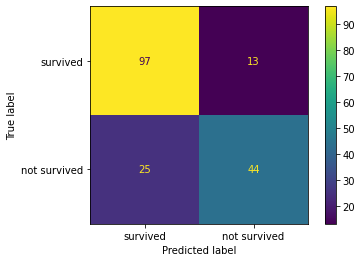

In [12]:
print("Test 2:")
model = construct_model(inputs, n=[256, 64])
print(model)
train_model(model, epochs=500,
            train_data=(trn_X,trn_y), test_data=(tst_X,tst_y))

Test 3:
Sequential(
  (0): Linear(in_features=11, out_features=16, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=2, bias=True)
)
   Accuracy  : 80.45%
   Train loss: 0.39611437916755676
   Test loss : 0.4669460952281952


precision: 0.7761615309839195
recall: 0.776536312849162
f1 score: 0.769457996557082


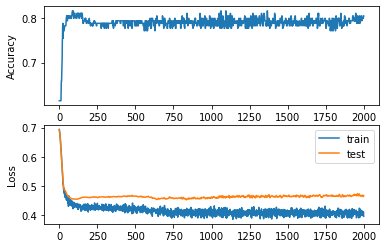

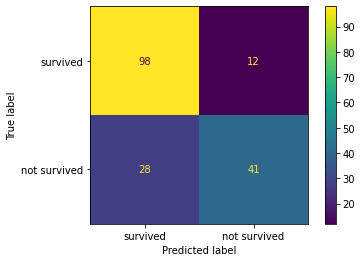

In [13]:
print("Test 3:")
model = construct_model(inputs, n=[16])
print(model)
train_model(model, epochs=2000,
            train_data=(trn_X,trn_y), test_data=(tst_X,tst_y))